In [1]:
curr_dir = '/user_data/vayzenbe/GitHub_Repos/ginn'

import sys
sys.path.insert(1, f'{curr_dir}/fmri')

import pandas as pd
import numpy as np
import pdb
import warnings
import os, argparse
import  matplotlib.pyplot as plt
import seaborn as sns



from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge
import brainiak.funcalign.srm
from scipy import stats
import statsmodels.api as sm
from nilearn import image, datasets, plotting, maskers, signal
import nibabel as nib
import random
import statsmodels.api as sm

import create_movie_rdms
import mvpd_movie_crossval

warnings.filterwarnings("ignore")
print('libraries loaded')

Libraries loaded...
libraries loaded
libraries loaded


In [2]:
human_predictor = '/lab_data/behrmannlab/vlad/ginn/fmri/hbn/derivatives/group_func'
model_predictor = '/lab_data/behrmannlab/vlad/ginn/modelling/model_ts'

exp_dir= f'ginn/fmri/hbn'
study_dir = f'/lab_data/behrmannlab/scratch/vlad/{exp_dir}'
subj_dir=f'{study_dir}/derivatives/preprocessed_data'
roi_dir = f'{study_dir}/derivatives/rois'

#subj = 'sub-pixar135'
#subj = 'sub-NDAREG930XPP'
file_suf = 'partly_cloudy'
clf = Ridge()

exp_dir= f'fmri/pixar'
file_suf = 'pixar_run-001_swrf'
#file_suf = 'movieDM'

all_subs = pd.read_csv(f'{curr_dir}/fmri/pixar-sub-info.csv')
#all_subs = pd.read_csv(f'{curr_dir}/fmri/HBN-Site-CBIC.csv')
#all_subs['participant_id'] = 'sub-' + all_subs['participant_id'].astype(str)

fix_tr = 0

In [3]:
def extract_whole_ts(curr_subs):

    raw_dir = f'/lab_data/behrmannlab/scratch/vlad/ginn/{exp_dir}'
    study_dir = f'/lab_data/behrmannlab/vlad/ginn/'
    out_dir = f'{study_dir}/{exp_dir}/derivatives/group_func'
    subj_dir=f'{raw_dir}/derivatives/preprocessed_data'

    '''
    load subs into numpy array
    '''
    print(f'extracting whole brain data...')
    n = 0
    all_data = []
    for sub in curr_subs['sub']:
        
        
        sub_ts = np.load(f'{subj_dir}/{sub}/timeseries/whole_brain_ts.npy')
        
        sub_ts = sub_ts[fix_tr:,:]
        #sub_ts = np.transpose(sub_ts)
        #sub_ts = np.expand_dims(sub_ts,axis =2)
        
        all_data.append(sub_ts)
        #sub_ts = np.reshape(sub_ts, [sub_ts.shape[1], sub_ts.shape[0], sub_ts.shape[2]])
        #pdb.set_trace()
        '''
        if n == 0:
            all_data = sub_ts
            
            n += 1
        else:
            
            all_data = np.concatenate((all_data,sub_ts), axis = 2)
        '''
    return all_data


In [4]:


curr_subs = mvpd_movie_crossval.get_existing_files(all_subs)
curr_subs['age'] = curr_subs['age'].apply(np.floor)
curr_subs['age'][curr_subs['age']>=18] = 18
curr_subs = curr_subs.drop_duplicates(subset ="sub",)
curr_subs = curr_subs.reset_index()
curr_subs = curr_subs[curr_subs['age']==18]




In [6]:
adult_lo = mvpd_movie_crossval.extract_roi_data(curr_subs,'rLO')
adult_ffa = mvpd_movie_crossval.extract_roi_data(curr_subs,'rFFA')
adult_a1 = mvpd_movie_crossval.extract_roi_data(curr_subs,'lA1')

adult_whole = extract_whole_ts(curr_subs)

extracting rLO data...
extracting rFFA data...
extracting lA1 data...
extracting whole brain data...


FileNotFoundError: [Errno 2] No such file or directory: '/lab_data/behrmannlab/scratch/vlad/ginn/fmri/hbn/derivatives/preprocessed_data/sub-NDAREL410HHK/timeseries/whole_brain_ts.npy'

In [17]:
"""
Extract top 10 whole brain pcs 
"""
whole_pcs = []
for ii in range(0,len(adult_whole)):
    pca = create_movie_rdms.extract_pc(adult_whole[ii], n_components = 10)
    
    whole_pcs.append(pca.transform(adult_whole[ii]))


In [31]:
'''regress out mean signal'''

global_signal = 'mean'
global_signal = 'pca'

if global_signal == 'mean':

    for ii in range(0,len(adult_lo)):
        adult_lo[ii] = signal.clean(adult_lo[ii],confounds = np.mean(adult_whole[ii],axis = 1), standardize_confounds=True)
        adult_ffa[ii] = signal.clean(adult_ffa[ii],confounds = np.mean(adult_whole[ii],axis = 1), standardize_confounds=True)
        adult_a1[ii] = signal.clean(adult_a1[ii],confounds = np.mean(adult_whole[ii],axis = 1), standardize_confounds=True)

if global_signal == 'pca':
    for ii in range(0,len(adult_lo)):
        adult_lo[ii] = signal.clean(adult_lo[ii],confounds = whole_pcs[ii], standardize_confounds=True)
        adult_ffa[ii] = signal.clean(adult_ffa[ii],confounds = whole_pcs[ii], standardize_confounds=True)
        adult_a1[ii] = signal.clean(adult_a1[ii],confounds = whole_pcs[ii], standardize_confounds=True)
        




In [25]:
import random 
random.shuffle(adult_lo)
random.shuffle(adult_ffa)
random.shuffle(adult_a1)

In [26]:
'''split adult data into halves'''
lo_data = []
lo_data.append(adult_lo[0:int(len(adult_lo)/2)])
lo_data.append(adult_lo[int(len(adult_lo)/2):])

ffa_data = []
ffa_data.append(adult_ffa[0:int(len(adult_lo)/2)])
ffa_data.append(adult_ffa[int(len(adult_lo)/2):])

a1_data = []
a1_data.append(adult_a1[0:int(len(adult_lo)/2)])
a1_data.append(adult_a1[int(len(adult_lo)/2):])




In [21]:
a1_data[0][0].shape


(750, 2584)

In [27]:

lo_rdm = [[],[]]
ffa_rdm = [[],[]]
a1_rdm = [[],[]]


for ii in range(0,len(lo_data[0])):
    
    for kk in range(0,2):
        _, rdm = create_movie_rdms.create_rdm(lo_data[kk][ii])    
        lo_rdm[kk].append(rdm)

        _, rdm = create_movie_rdms.create_rdm(ffa_data[kk][ii])
        ffa_rdm[kk].append(rdm)

        _, rdm = create_movie_rdms.create_rdm(a1_data[kk][ii])
        a1_rdm[kk].append(rdm)
lo_rdm = np.array(lo_rdm)
ffa_rdm = np.array(ffa_rdm)
a1_rdm = np.array(a1_rdm)

In [28]:

lo_mean=[]
ffa_mean=[]
a1_mean=[]

for kk in range(0,2):
    lo_mean.append(np.sum(lo_rdm[kk,:,:],axis = 0)/lo_rdm.shape[1])
    ffa_mean.append(np.sum(ffa_rdm[kk,:,:],axis = 0)/ffa_rdm.shape[1])
    a1_mean.append(np.sum(a1_rdm[kk,:,:],axis = 0)/a1_rdm.shape[1])

In [29]:
print('lo vs lo', np.corrcoef(lo_mean[0],lo_mean[1])[0][1])
print('lo vs ffa', np.corrcoef(lo_mean[0],ffa_mean[1])[0][1])
print('lo vs a1', np.corrcoef(lo_mean[0],a1_mean[1])[0][1])

print('ffa vs ffa', np.corrcoef(ffa_mean[0],ffa_mean[1])[0][1])
print('ffa vs a1', np.corrcoef(ffa_mean[0],a1_mean[1])[0][1])
print('a1 vs a1', np.corrcoef(a1_mean[0],a1_mean[1])[0][1])

lo vs lo 0.48691787829408756
lo vs ffa 0.5057162833291473
lo vs a1 0.45914946981201815
ffa vs ffa 0.29245180905974827
ffa vs a1 0.438004257749538
a1 vs a1 0.5092164108066606


In [88]:
sub_vol = f'{subj_dir}/{subj}/{subj}_task-pixar_run-001_swrf_bold.nii.gz'
    
whole_brain_mask = image.binarize_img(image.load_img(f'{subj_dir}/{subj}/{subj}_analysis_mask.nii.gz'))
first_volume = image.index_img(sub_vol, 0)

In [25]:
def extract_roi_data(bold_vol, roi):

    '''extracts roi data'''
    masker = maskers.NiftiMasker(mask_img=roi)
    
    masker.fit(bold_vol)
    roi_data = masker.transform(bold_vol)

    return roi_data
    

In [32]:
'''extract roi data'''

lo_sub = extract_roi_data(sub_vol, lo_roi)
a1_sub  = extract_roi_data(sub_vol, a1_roi)
ffa_sub = extract_roi_data(sub_vol, ffa_roi)

lo_avg = extract_roi_data(mean_func, lo_roi)
a1_avg = extract_roi_data(mean_func, a1_roi)
ffa_avg = extract_roi_data(mean_func, ffa_roi)

In [27]:
def extract_pc(data, n_components=None):

    """
    Extract principal components
    if n_components isn't set, it will extract all it can
    """
    
    pca = PCA(n_components = n_components)
    pca.fit(data)
    
    return pca

# %%
def calc_pc_n(pca, thresh):
    '''
    Calculate how many PCs are needed to explain X% of data
    
    pca - result of pca analysis
    thresh- threshold for how many components to keep
    '''
    
    explained_variance = pca.explained_variance_ratio_
    
    var = 0
    for n_components, ev in enumerate(explained_variance):
        var += ev #add each PC's variance to current variance
        #print(n_comp, ev, var)

        if var >=thresh: #once variance > than thresh, stop
            break
    return n_components+1

In [35]:
lo_train = lo_avg[0:int(lo_avg.shape[0]/2),:]
lo_test = lo_avg[int(lo_avg.shape[0]/2):,:]

ffa_train = ffa_avg[0:int(ffa_avg.shape[0]/2),:]
ffa_test = ffa_avg[int(ffa_avg.shape[0]/2):,:]

a1_train = a1_avg[0:int(a1_avg.shape[0]/2),:]
a1_test = a1_avg[int(a1_avg.shape[0]/2):,:]

In [36]:
"""Run PCA on train, and apply to test"""

lo_n = calc_pc_n(extract_pc(lo_train), 0.9)
lo_pca = extract_pc(lo_train, lo_n)
lo_train_pca = lo_pca.transform(lo_train)
lo_test_pca = lo_pca.transform(lo_test)

ffa_n = calc_pc_n(extract_pc(ffa_train), 0.9)
ffa_pca = extract_pc(ffa_train, ffa_n)
ffa_train_pca = ffa_pca.transform(ffa_train)
ffa_test_pca = ffa_pca.transform(ffa_test)

a1_n = calc_pc_n(extract_pc(a1_train), 0.9)
a1_pca = extract_pc(a1_train, a1_n)
a1_train_pca = a1_pca.transform(a1_train)
a1_test_pca = a1_pca.transform(a1_test)

In [38]:

def get_existing_files(curr_subs):
    
    sub_file =pd.DataFrame(columns=['sub','age'])
    for sub in enumerate(curr_subs['participant_id']):
        img = f'{subj_dir}/sub-{sub[1]}/sub-{sub[1]}_task-{file_suf}_bold.nii.gz'
        
        if os.path.exists(img):
            
            
            sub_file = sub_file.append(pd.Series([sub[1], curr_subs['Age'][sub[0]]], index = sub_file.columns), ignore_index = True)

    return sub_file


# %%

def extract_indiv_roi_data(curr_subs, roi):
    '''
    load subs into numpy array
    '''
    print(f'extracting {roi} data...')
    n = 0
    all_data = []
    for sub in curr_subs['sub']:
        
        
        sub_ts = np.load(f'{subj_dir}/sub-{sub}/timeseries/{roi}_ts_all.npy')
        sub_ts = np.transpose(sub_ts)
        #sub_ts = np.expand_dims(sub_ts,axis =2)
        
        all_data.append(sub_ts)
        #sub_ts = np.reshape(sub_ts, [sub_ts.shape[1], sub_ts.shape[0], sub_ts.shape[2]])
        #pdb.set_trace()
        '''
        if n == 0:
            all_data = sub_ts
            
            n += 1
        else:
            
            all_data = np.concatenate((all_data,sub_ts), axis = 2)
        '''
    return all_data

In [39]:
sub_list = pd.read_csv(f'{curr_dir}/fmri/HBN-Site-CBIC.csv')

curr_subs = get_existing_files(sub_list)
curr_subs = curr_subs[curr_subs['age']>=18]
curr_subs = curr_subs.drop_duplicates(subset ="sub",)
curr_subs = curr_subs.reset_index()

file_suf = 'movieDM'
lo_data = extract_indiv_roi_data(curr_subs, 'rLO')
ffa_data = extract_indiv_roi_data(curr_subs, 'rFFA')
a1_data = extract_indiv_roi_data(curr_subs, 'lA1')

extracting rLO data...
extracting rFFA data...
extracting lA1 data...


In [46]:
"""Extract SRM"""

srm = brainiak.funcalign.srm.SRM(n_iter=30, features=50)
srm.fit(lo_data)
lo_seed = np.transpose(srm.s_)

srm = brainiak.funcalign.srm.SRM(n_iter=30, features=50)
srm.fit(ffa_data)
ffa_seed = np.transpose(srm.s_)

srm = brainiak.funcalign.srm.SRM(n_iter=30, features=50)
srm.fit(a1_data)
a1_seed = np.transpose(srm.s_)

In [49]:
def calc_mvpd(seed, train_target, test_target, target_pca):
    """
    Conduct regression by iteratively fitting all seed PCs to target PCs
    
    """
    train_seed = seed[0:int(seed.shape[0]/2),:]
    test_seed = seed[int(seed.shape[0]/2):,:]

    clf = LinearRegression()
    all_scores = []
    for pcn in range(0,len(target_pca.explained_variance_ratio_)):
        
        
        clf.fit(train_seed, train_target[:,pcn]) #fit seed PCs to target
        pred_ts = clf.predict(test_seed)
        corr = np.corrcoef(pred_ts, test_target[:,pcn])[0,1]
        #r_squared = clf.score(seed_comps,target_comps[:,pcn]) 
        
        weighted_corr = corr * target_pca.explained_variance_ratio_[pcn]
        all_scores.append(weighted_corr)
        #all_scores.append(r_squared)

    final_corr = np.sum(all_scores)/(np.sum(target_pca.explained_variance_ratio_))
    #final_corr = np.mean(all_scores)
    return final_corr


In [47]:
lo_seed.shape

(750, 50)

In [51]:
print(f'LO LO mvpd', calc_mvpd(lo_seed, lo_train_pca, lo_test_pca, lo_pca))
print(f'FFA LO mvpd', calc_mvpd(lo_seed, ffa_train_pca, ffa_test_pca, ffa_pca))
print(f'A1 LO mvpd', calc_mvpd(lo_seed, a1_train_pca, a1_test_pca, a1_pca))

print(f'FFA FFA mvpd', calc_mvpd(ffa_seed, ffa_train_pca, ffa_test_pca, ffa_pca))
print(f'LO FFA mvpd', calc_mvpd(ffa_seed, lo_train_pca, lo_test_pca, lo_pca))
print(f'A1 FFA mvpd', calc_mvpd(ffa_seed, a1_train_pca, a1_test_pca, a1_pca))

print(f'A1 A1 mvpd', calc_mvpd(a1_seed, a1_train_pca, a1_test_pca, a1_pca))

LO LO mvpd 0.5447687988475347
FFA LO mvpd 0.22363715188348143
A1 LO mvpd 0.3120999651693629
FFA FFA mvpd 0.36896697711445164
LO FFA mvpd 0.3900226045165741
A1 FFA mvpd 0.23080486487122884
A1 A1 mvpd 0.4576056265049145


In [ ]:
'''for mean data'''
lo_n = calc_pc_n(extract_pc(lo_avg),.9) #determine number of PCs in train_data using threshold
lo_avg_pca = extract_pc(lo_avg, lo_n) #conduct PCA one more time with that number of PCs
lo_avg_pcs = lo_avg_pca.transform(lo_avg) #transform train data in PCs

a1_n = calc_pc_n(extract_pc(a1_avg),.9) #determine number of PCs in train_data using threshold
a1_avg_pca = extract_pc(a1_avg, a1_n) #conduct PCA one more time with that number of PCs
a1_avg_pcs = a1_avg_pca.transform(a1_avg) #transform train data in PCs

ffa_n = calc_pc_n(extract_pc(ffa_avg),.9) #determine number of PCs in train_data using threshold
ffa_avg_pca = extract_pc(ffa_avg, ffa_n) #conduct PCA one more time with that number of PCs
ffa_avg_pcs = ffa_avg_pca.transform(ffa_avg) #transform train data in PCs

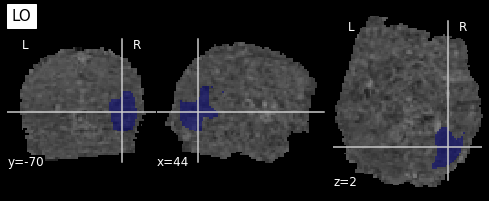

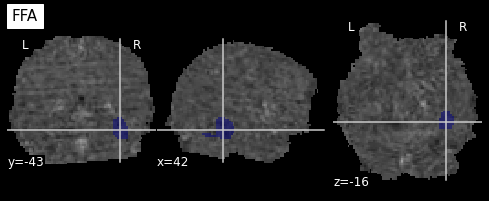

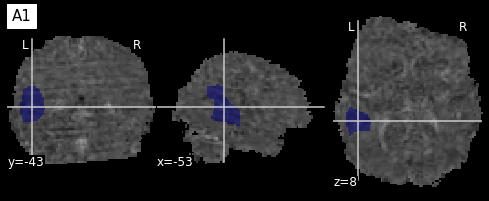

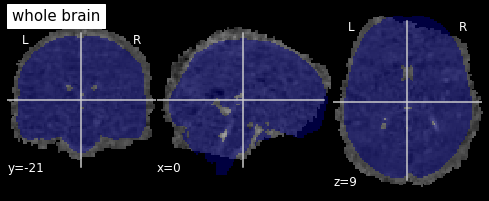

In [10]:
'''plot ROIs'''
plotting.plot_roi(lo_roi, first_volume, title='LO', alpha=0.5)
plotting.plot_roi(ffa_roi, first_volume, title='FFA',alpha=0.5)
plotting.plot_roi(a1_roi, first_volume, title='A1',alpha=0.5)
plotting.plot_roi(whole_brain_mask, first_volume, title='whole brain',alpha=0.5)

sub size: (91, 109, 91, 750)
mean func size: (91, 109, 91, 750)


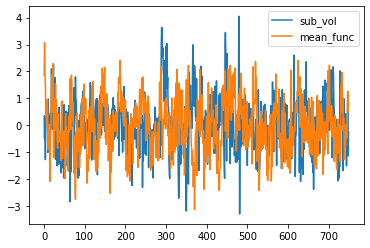

In [6]:
print('sub size:', sub_vol.shape)
print('mean func size:', mean_func.shape)

plt.plot(sub_vol.get_data()[45,45,50,:], label='sub_vol')
plt.plot(mean_func.get_data()[45,45,50,:], label='mean_func')
plt.legend()

In [28]:
"""Run PCA on sub and mean data"""

'''for sub data'''
lo_n = calc_pc_n(extract_pc(lo_sub),.9) #determine number of PCs in train_data using threshold        
lo_sub_pca = extract_pc(lo_sub, lo_n) #conduct PCA one more time with that number of PCs
lo_sub_pcs = lo_sub_pca.transform(lo_sub) #transform train data in PCs       

a1_n = calc_pc_n(extract_pc(a1_sub),.9) #determine number of PCs in train_data using threshold
a1_sub_pca = extract_pc(a1_sub, a1_n) #conduct PCA one more time with that number of PCs
a1_sub_pcs = a1_sub_pca.transform(a1_sub) #transform train data in PCs

ffa_n = calc_pc_n(extract_pc(ffa_sub),.9) #determine number of PCs in train_data using threshold
ffa_sub_pca = extract_pc(ffa_sub, ffa_n) #conduct PCA one more time with that number of PCs
ffa_sub_pcs = ffa_sub_pca.transform(ffa_sub) #transform train data in PCs




In [14]:
print('lo data shape:', lo_sub.shape)
print('a1 data shape:', a1_sub.shape)
print('ffa data shape:', ffa_sub.shape)



lo data shape: (750, 3562)
a1 data shape: (750, 2584)
ffa data shape: (750, 650)


In [6]:
whole_brain_mask = image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_brain_mask.nii.gz')
sub_vol = image.clean_img(image.load_img(f'{subj_dir}/{subj}/{subj}_task-movieDM_bold.nii.gz'),detrend=True,standardize=True)
mean_func = image.clean_img(image.load_img(f'{human_predictor}/mean_task-movieDM_bold_18.nii.gz'),detrend=True,standardize=True)

#bold_vol = image.load_img(f'{subj_dir}/{subj}/{subj}_task-pixar_run-001_swrf_bold.nii.gz')
#whole_brain_mask = image.load_img(f'{subj_dir}/{subj}/{subj}_analysis_mask.nii.gz')


first_volume = image.index_img(sub_vol, 0)
first_mean_vol = image.index_img(mean_func, 0)


In [7]:
'''load rois'''
lo_roi = image.binarize_img(image.load_img(f'{roi_dir}/rLO.nii.gz'))
ffa_roi = image.binarize_img(image.load_img(f'{roi_dir}/rFFA.nii.gz'))
a1_roi = image.binarize_img(image.load_img(f'{roi_dir}/lA1.nii.gz'))



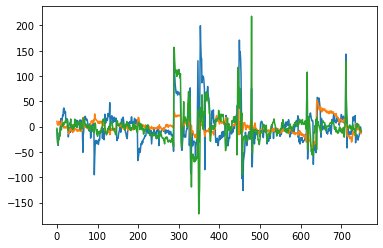

In [33]:
plt.plot(lo_sub_pcs[:,0], label='lo_sub_pcs')
plt.plot(ffa_sub_pcs[:,0], label='ffa_sub_pcs')
plt.plot(a1_sub_pcs[:,0], label='a1_sub_pcs')

In [26]:
'''mean to sub corrs'''
print('ffa a1 corr', np.corrcoef(ffa_sub_pcs[:,0], a1_avg_pcs[:,0]))
print('ffa lo corr', np.corrcoef(ffa_sub_pcs[:,0], lo_avg_pcs[:,0]))
print('a1 lo corr', np.corrcoef(a1_sub_pcs[:,0], lo_avg_pcs[:,0]))

ffa a1 corr [[1.         0.03906234]
 [0.03906234 1.        ]]
ffa lo corr [[1.         0.10960267]
 [0.10960267 1.        ]]
a1 lo corr [[ 1.         -0.07240852]
 [-0.07240852  1.        ]]


In [27]:
''' roi to roi corrs'''
print('ffa a1 corr', np.corrcoef(ffa_sub_pcs[:,0], a1_sub_pcs[:,0]))
print('ffa lo corr', np.corrcoef(ffa_sub_pcs[:,0], lo_sub_pcs[:,0]))
print('a1 lo corr', np.corrcoef(a1_sub_pcs[:,0], lo_sub_pcs[:,0]))

print('ffa a1 corr', np.corrcoef(ffa_avg_pcs[:,0], a1_avg_pcs[:,0]))
print('ffa lo corr', np.corrcoef(ffa_avg_pcs[:,0], lo_avg_pcs[:,0]))
print('a1 lo corr', np.corrcoef(a1_avg_pcs[:,0], lo_avg_pcs[:,0]))

ffa a1 corr [[1.         0.31520827]
 [0.31520827 1.        ]]
ffa lo corr [[1.         0.16734564]
 [0.16734564 1.        ]]
a1 lo corr [[1.         0.55231715]
 [0.55231715 1.        ]]
ffa a1 corr [[ 1.         -0.37616657]
 [-0.37616657  1.        ]]
ffa lo corr [[1.         0.85822642]
 [0.85822642 1.        ]]
a1 lo corr [[ 1.         -0.37798169]
 [-0.37798169  1.        ]]


In [49]:
def calc_mvpd(seed_comps,target_comps, target_pca):
    """
    Conduct regression by iteratively fitting all seed PCs to target PCs
    
    """
    clf = LinearRegression()
    all_scores = []
    for pcn in range(0,len(target_pca.explained_variance_ratio_)):
        
        clf.fit(seed_comps, target_comps[:,pcn]) #fit seed PCs to target
        r_squared = clf.score(seed_comps,target_comps[:,pcn]) 
        
        weighted_corr = r_squared * target_pca.explained_variance_ratio_[pcn]
        all_scores.append(weighted_corr)
        #all_scores.append(r_squared)

    final_corr = np.sum(all_scores)/(np.sum(target_pca.explained_variance_ratio_))
    #final_corr = np.mean(all_scores)
    return final_corr

In [ ]:
"""try predicting individual voxels"""

"""fit pca/srm on train and transform test"""

"""multivariate global signal regression"""

"""take out 10s between movie splits"""

In [74]:
ffa_sub_pcs.shape

(750, 50)

In [80]:
''' mvpd with avg brain'''

print('ffa a1 mvpd', calc_mvpd(a1_avg_pcs,ffa_sub_pcs,  ffa_sub_pca))
print('ffa lo mvpd', calc_mvpd( lo_avg_pcs, ffa_sub_pcs,ffa_sub_pca))
print('a1 lo mvpd', calc_mvpd( lo_avg_pcs, a1_sub_pcs, lo_sub_pca))
print('lo lo mvpd', calc_mvpd( lo_avg_pcs, lo_sub_pcs, lo_sub_pca))

ffa a1 mvpd 0.04347905946010275
ffa lo mvpd -0.00045445614644244254
a1 lo mvpd -0.018352578612543816
lo lo mvpd -0.05110102205351969


In [81]:
def cross_val_srm(target_data,seed_data, n_feats):
    print('running cross validation...')
    roi_data = np.asanyarray(roi_data)
    
    # Create the SRM objects
    srm_target = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=n_feats)
    srm_seed = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=n_feats)

    score = []
    
    #split into folds
    for fold in range(0,2):
        
        if fold == 0:
            #split data and run SRM on target
            train_target = target_data[:,0:int(target_data.shape[1]/2)]
            test_target = target_data[:,int(target_data.shape[1]/2):]

            srm_target.fit(train_target)
            train_target = srm_target.s_
            test_target = srm_target.transform(test_target)

            train_seed = seed_data[:,0:int(seed_data.shape[1]/2)]
            test_seed = seed_data[:,int(seed_data.shape[1]/2):]

            #split data and run SRM on target
            srm_seed.fit(train_seed)
            train_seed = srm_seed.s_
            test_seed = srm_seed.transform(test_seed)

            srm_target = srm_seed.fit(target_data)
            train_srm = srm_target.s_
            test_srm = srm_target.transform(target_data)

        elif fold ==1:
            #split data and run SRM on target
            train_target = target_data[:,int(target_data.shape[1]/2):]
            test_target = target_data[:,0:int(target_data.shape[1]/2)]

            srm_target.fit(train_target)
            train_target = srm_target.s_
            test_target = srm_target.transform(test_target)

            train_seed = seed_data[:,int(seed_data.shape[1]/2):]
            test_seed = seed_data[:,0:int(seed_data.shape[1]/2)]

            #split data and run SRM on target
            srm_seed.fit(train_seed)
            train_seed = srm_seed.s_
            test_seed = srm_seed.transform(test_seed)

            srm_target = srm_seed.fit(target_data)
            train_srm = srm_target.s_
            test_srm = srm_target.transform(target_data)

        
        curr_score = calc_mvpd(train_seed, test_seed, train_target, test_target)
        score.append(curr_score)
    
    return np.mean(score)

In [82]:
def calc_mvpd(train_seed, test_seed, train_data, test_data):
    """
    Conduct regression by iteratively fitting all seed PCs to target PCs
    
    """
    #pdb.set_trace()
    all_scores = []

    for kk in range(0,train_data.shape[1]):
        clf.fit(train_seed, train_data[:,kk])
        pred_ts = clf.predict(test_seed)

        all_scores.append(np.corrcoef(pred_ts,test_data[:,kk])[0])


       #all_scores.append(r_squared)

    #final_score = np.sum(all_scores)/(np.sum(target_pca.explained_variance_ratio_))
    final_score = np.mean(all_scores)
    return final_score

In [24]:
len(lo_data)

20

In [18]:
sub_list = pd.read_csv(f'{curr_dir}/fmri/HBN-Site-CBIC.csv')

curr_subs = get_existing_files(sub_list)
sub_list

,participant_id,release_number,Bold.Sequence,Sex,Age,EHQ_Total,Commercial_Use,Full_Pheno
0,NDARAM873GAC,R3,abcd,0,7.921629,-80.00,Yes,Yes
1,NDARAV519RND,R3,abcd,0,9.337326,56.67,Yes,Yes
2,NDARAY461TZZ,R3,abcd,0,14.895619,93.40,Yes,Yes
3,NDARAY461TZZ,R3,abcd,0,14.895619,93.40,Yes,Yes
4,NDARBT640EBN,R3,abcd,1,10.344855,100.00,Yes,Yes
...,...,...,...,...,...,...,...,...
1400,NDARZJ539CD9,R9,cmrr,0,9.890143,91.14,Yes,Yes
1401,NDARZR180BM6,R9,cmrr,0,14.925621,97.85,Yes,No
1402,NDARZW619BDL,R9,cmrr,0,10.120123,100.00,Yes,Yes
1403,NDARZX745YLZ,R9,cmrr,0,16.288501,100.00,Yes,Yes


In [58]:


full_lo_rdm,lo_rdm_vox = create_rdm(lo_avg)
_, lo_sub = create_rdm(lo_sub)


full_a1_rdm,a1_rdm_vox = create_rdm(a1_avg)

full_ffa_rdm,ffa_rdm_vox = create_rdm(ffa_avg)


In [59]:
print('ffa lo corr', np.corrcoef(ffa_rdm_vox, lo_sub))
print('a1 lo corr', np.corrcoef(a1_rdm_vox, lo_sub))
print('lo lo corr', np.corrcoef(lo_rdm_vox, lo_sub))


ffa lo corr [[1.         0.07886326]
 [0.07886326 1.        ]]
a1 lo corr [[1.         0.10248871]
 [0.10248871 1.        ]]
lo lo corr [[1.         0.10478618]
 [0.10478618 1.        ]]


In [57]:
print('lo a1 corr', np.corrcoef(lo_rdm_vox, a1_rdm_vox))
print('lo ffa corr', np.corrcoef(lo_rdm_vox, ffa_rdm_vox))
print('a1 ffa corr', np.corrcoef(a1_rdm_vox, ffa_rdm_vox))


lo a1 corr [[1.        0.3507673]
 [0.3507673 1.       ]]
lo ffa corr [[1.         0.37298007]
 [0.37298007 1.        ]]
a1 ffa corr [[1.         0.25519895]
 [0.25519895 1.        ]]


<AxesSubplot:>

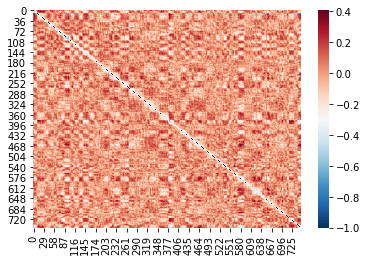

In [62]:
import seaborn as sns
sns.heatmap(full_lo_rdm, cmap='RdBu_r')

<AxesSubplot:>

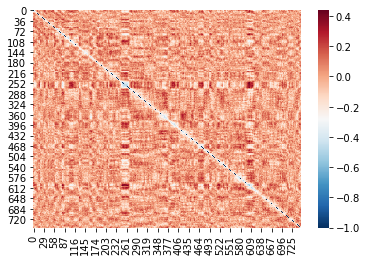

In [63]:
sns.heatmap(full_a1_rdm, cmap='RdBu_r')

In [53]:
'''mvpd with models'''
model_random_ts = np.load(f'{model_predictor}/cornet_z_sl_random_aIT_DM-clip_ts.npy')
model_in_ts = np.load(f'{model_predictor}/cornet_z_sl_imagenet_noface_aIT_DM-clip_ts.npy')

print('lo random mvpd', calc_mvpd( model_random_ts, lo_avg_pcs,lo_sub_pca))
print('lo imagenet mvpd', calc_mvpd( model_in_ts, lo_avg_pcs,lo_sub_pca))
print('a1 random mvpd', calc_mvpd( model_random_ts,a1_avg_pcs, a1_sub_pca))
print('a1 imagenet mvpd', calc_mvpd( model_in_ts,a1_avg_pcs,a1_sub_pca))
print('ffa random mvpd', calc_mvpd( model_random_ts,ffa_avg_pcs, ffa_sub_pca))
print('ffa imagenet mvpd', calc_mvpd( model_in_ts,ffa_avg_pcs, ffa_sub_pca))


lo random mvpd 0.3164021108499382
lo imagenet mvpd 0.6359265707119729
a1 random mvpd 0.2928861255529465
a1 imagenet mvpd 0.6161325342425114
ffa random mvpd 0.2557621747433569
ffa imagenet mvpd 0.5144157049040022


In [65]:
in_rdm,in_model_rsm = create_rdm(model_in_ts)
random_rdm,random_model_rsm = create_rdm(model_random_ts)

<AxesSubplot:>

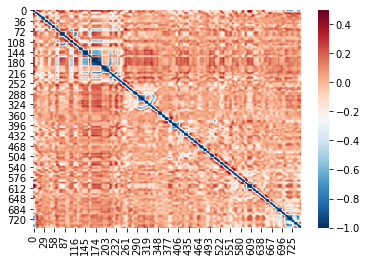

In [67]:
sns.heatmap(in_rdm, cmap='RdBu_r')


<AxesSubplot:>

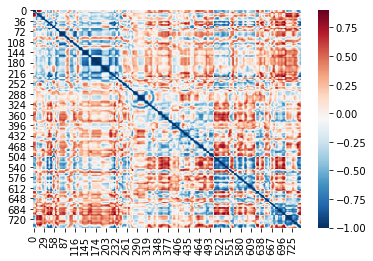

In [68]:
sns.heatmap(random_rdm, cmap='RdBu_r')

In [69]:
np.corrcoef(in_model_rsm, random_model_rsm)

array([[1.        , 0.49403867],
       [0.49403867, 1.        ]])

In [ ]:
model_random_ts = np.load(f'{model_predictor}/cornet_z_sl_random_aIT_DM-clip_ts.npy')
model_in_ts = np.load(f'{model_predictor}/cornet_z_sl_imagenet_noface_aIT_DM-clip_ts.npy')

DNN a1


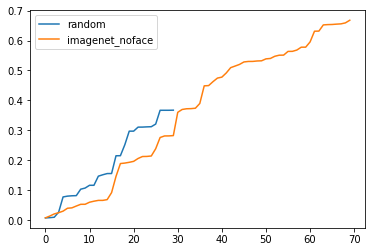

In [30]:
print('DNN a1')
a1_data = all_rois
for rr in range(0,len(rois)):
    plt.plot(a1_data[rr], label=rois[rr])
plt.legend(loc="upper left")


In [47]:
model_random_ts = np.load(f'{model_predictor}/cornet_z_sl_random_aIT_DM-clip_ts.npy')
model_in_ts = np.load(f'{model_predictor}/cornet_z_sl_imagenet_noface_aIT_DM-clip_ts.npy')
#model_ts = np.load(f'{model_predictor}/cornet_z_sl_random_aIT_DM-clip_ts.npy')
adult_srm = np.transpose(np.load(f'{human_predictor}/srm_rLO_18_50.npy'))
adult_mean = np.transpose(np.load(f'{human_predictor}/mean_task-movieDM_bold_18.nii.gz'))


a1_ts = np.transpose(np.load(f'{human_predictor}/srm_lA1_18_50.npy'))
model_ts= stats.zscore(model_random_ts, axis=0, ddof=1)
model_ts= stats.zscore(model_in_ts, axis=0, ddof=1)
adult_ts= stats.zscore(adult_ts, axis=0, ddof=1)
a1_ts= stats.zscore(a1_ts, axis=0, ddof=1)
#adult_ts = adult_ts[5:,:]

In [48]:
adu.shape

NameError: name 'adu' is not defined

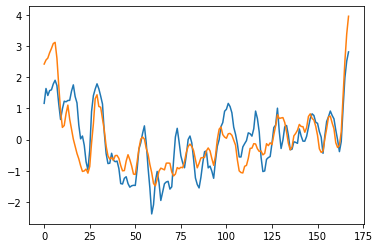

In [49]:
plt.plot(a1_ts[:,0])
plt.plot(adult_ts[:,0])

In [50]:
np.corrcoef(a1_ts[:,0], adult_ts[:,0])

array([[1.        , 0.80373452],
       [0.80373452, 1.        ]])

In [55]:
def create_rdm(ts):
    """
    Create RDM
    """
    rdm = np.corrcoef(ts) * -1
    rdm_vec = rdm[np.triu_indices(n=ts.shape[0],k=1)] #remove lower triangle
    
    return rdm, rdm_vec

In [53]:
def extract_mv_ts(bold_vol, roi):
    """
    extract multivariate time course from ROI
    """

    #load seed
    roi = image.get_data(roi)
    bold_vol = image.get_data(bold_vol)
    #Just ensure its all binary
    roi[roi>0] = 1
    roi[roi<=0] = 0
    reshaped_roi = np.reshape(roi, whole_brain_mask.shape +(1,))
    masked_img = reshaped_roi*bold_vol

    #extract voxel resposnes from within mask
    mv_ts = masked_img.reshape(-1, bold_vol.shape[3]) #reshape into rows (voxels) x columns (time)
    mv_ts =mv_ts[~np.all(mv_ts == 0, axis=1)] #remove voxels that are 0 (masked out)
    mv_ts = np.transpose(mv_ts)

    print('Seed data extracted...')

    return mv_ts

In [77]:
'''extract data'''

model_ts = np.load(f'{model_predictor}/cornet_z_sl_imagenet_noface_aIT_DM-clip_ts.npy')
adult_ts = np.transpose(np.load(f'{human_predictor}/srm_rLO_18_50.npy'))
lo = extract_mv_ts(bold_vol, lo_roi)
a1 = extract_mv_ts(bold_vol, a1_roi)
whole = extract_mv_ts(bold_vol, whole_brain_mask)



Seed data extracted...
Seed data extracted...
Seed data extracted...


In [79]:
whole_masker = maskers.NiftiMasker(mask_img=whole_brain_mask, detrend = True, standardize = True)
whole_masker.fit(bold_vol)
whole_ts = whole_masker.transform(bold_vol)
mean_ts = np.mean(whole_ts, axis=1)

In [81]:
model_ts = np.load(f'{model_predictor}/cornet_z_sl_imagenet_noface_aIT_DM-clip_ts.npy')
adult_ts = np.transpose(np.load(f'{human_predictor}/srm_rLO_18_50.npy'))

bold_vol_clean = image.clean_img(bold_vol, confounds = mean_ts, detrend = True)

lo_masker = maskers.NiftiMasker(lo_roi, detrend=True, standardize=True)
lo_masker.fit(bold_vol_clean)
lo = lo_masker.transform(bold_vol)

a1_masker = maskers.NiftiMasker(a1_roi, detrend=True, standardize=True)
a1_masker.fit(bold_vol_clean)
a1 = a1_masker.transform(bold_vol)


In [85]:
'''normalize and reduce dimensionality'''

model_ts= stats.zscore(model_ts, axis=0, ddof=1)
adult_ts= stats.zscore(adult_ts, axis=0, ddof=1)


lo_n = calc_pc_n(extract_pc(lo),.9) #determine number of PCs in train_data using threshold        

lo_pca = extract_pc(lo, lo_n) #conduct PCA one more time with that number of PCs
lo_comps = lo_pca.transform(lo) #transform train data in PCs       

a_n = calc_pc_n(extract_pc(a1),.9) #determine number of PCs in train_data using threshold
a1_pca = extract_pc(a1, a_n) #conduct PCA one more time with that number of PCs
a1_comps = a1_pca.transform(a1) #transform train data in PCs

_,lo_rdm_vox = create_rdm(lo)
_,lo_rdm_pc = create_rdm(lo_comps)

_, a1_rdm_vox = create_rdm(a1)
_, a1_rdm_pc = create_rdm(a1_comps)

_,model_rdm = create_rdm(model_ts)


In [86]:
lo.shape

(168, 4142)

In [87]:
print(lo.shape, a1.shape)
print(lo_comps.shape, a1_comps.shape)
#print(model_ts.shape)

(168, 4142) (168, 2067)
(168, 19) (168, 19)
(750, 70)


In [88]:
lo_comps= stats.zscore(lo_comps, axis=0, ddof=1)
a1_comps= stats.zscore(a1_comps, axis=0, ddof=1)

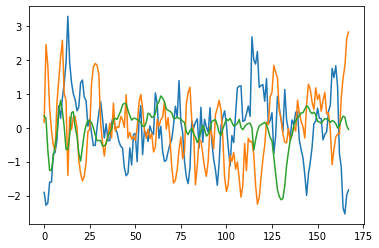

In [95]:
plt.plot(lo_comps[:,0], label='lo_comps')
plt.plot(a1_comps[:,0], label='a1_comps')
plt.plot(mean_ts, label='mean_ts')

In [90]:
print(np.corrcoef(lo_comps[:,0], a1_comps[:,0]))

[[1.         0.85614014]
 [0.85614014 1.        ]]


In [92]:
'''correlate RDMs'''

print(np.corrcoef(lo_rdm_pc,lo_rdm_vox))
print(np.corrcoef(lo_rdm_vox, a1_rdm_vox))
print(np.corrcoef(lo_rdm_pc, a1_rdm_pc))

#print(np.corrcoef(lo_rdm_pc, model_rdm))

[[1.         0.53854045]
 [0.53854045 1.        ]]
[[1.         0.53467698]
 [0.53467698 1.        ]]
[[1.         0.64324863]
 [0.64324863 1.        ]]


array([[1.        , 0.57567739],
       [0.57567739, 1.        ]])

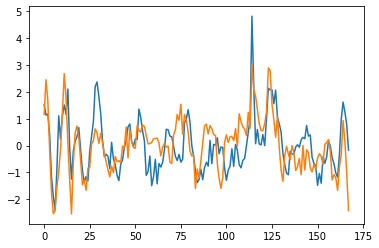

In [93]:
plt.plot(lo_comps[:,1])
plt.plot(a1_comps[:,1])
np.corrcoef(lo_comps[:,1], a1_comps[:,1])

In [69]:
np.corrcoef(a1_comps[:,0], mean_ts)

array([[1.        , 0.86469677],
       [0.86469677, 1.        ]])

In [29]:
"""
Test model
"""

rois = ['random','imagenet_noface']
sub_comps = a1_comps
sub_pca = a1_pca
all_rois = []
for roi in rois:
    adult_ts = np.load(f'{model_predictor}/cornet_z_sl_{roi}_aIT_DM-clip_ts.npy')
    all_scores = []
    for kk in range(0,adult_ts.shape[1]):
        seed_ts = adult_ts[:,0:kk+1]
        
        curr_score = []
        for jj in range(0,sub_comps.shape[1]):
            
            mod = sm.OLS( sub_comps[:,0],seed_ts).fit()
            r_squared = mod.rsquared

            weighted_corr = r_squared * sub_pca.explained_variance_ratio_[jj]
            curr_score.append(weighted_corr)
        final_corr = np.sum(curr_score)/(np.sum(sub_pca.explained_variance_ratio_))
        all_scores.append(final_corr)
    all_rois.append(all_scores)

In [20]:
"""
Test ROIs
"""

rois = ['rLO','lLO','lFFA','rFFA']
sub_comps = a1_comps
sub_pca = a1_pca
all_rois = []
for roi in rois:
    adult_ts = np.transpose(np.load(f'{human_predictor}/srm_{roi}_18_50.npy'))
    all_scores = []
    for kk in range(0,adult_ts.shape[1]):
        seed_ts = adult_ts[:,0:kk+1]
        
        curr_score = []
        for jj in range(0,sub_comps.shape[1]):
            
            mod = sm.OLS( sub_comps[:,0],seed_ts).fit()
            r_squared = mod.rsquared

            weighted_corr = r_squared * sub_pca.explained_variance_ratio_[jj]
            curr_score.append(weighted_corr)
        final_corr = np.sum(curr_score)/(np.sum(sub_pca.explained_variance_ratio_))
        all_scores.append(final_corr)
    all_rois.append(all_scores)

lo


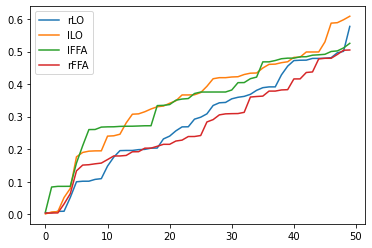

In [12]:
print('lo')
lo_data = all_rois
for rr in range(0,len(rois)):
    plt.plot(lo_data[rr], label=rois[rr])
plt.legend(loc="upper left")


a1


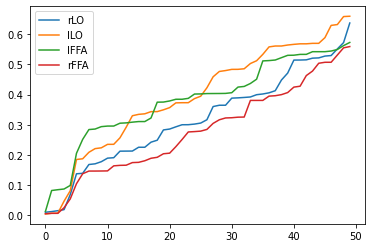

In [21]:
print('a1')
a1_data = all_rois
for rr in range(0,len(rois)):
    plt.plot(a1_data[rr], label=rois[rr])
plt.legend(loc="upper left")


In [24]:
sub_file = f'{subj_dir}/sub-NDAREG930XPP/sub-NDAREG930XPP_task-movieDM_bold.nii.gz'
bold_vol = image.load_img(sub_file) #load data
affine = bold_vol.affine #get affine

In [25]:
test_slice = bold_vol.get_data()[:,:,0]
test_slice = nib.Nifti1Image(test_slice, affine)

In [17]:
roi = f'{study_dir}/derivatives/rois/rA1.nii.gz'

In [28]:
plotting.view_img(bold_vol)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See https://nilearn.github.io/stable/manipulating_images/input_output.html.

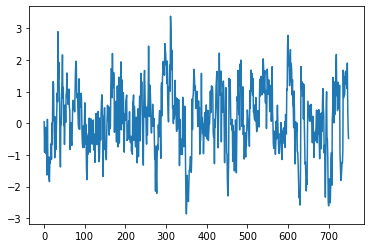

In [35]:
plt.plot(sub_ts[:,0])

In [40]:
np.corrcoef(a1[:,0],adult_ts[:,0])

array([[1.       , 0.0459994],
       [0.0459994, 1.       ]])

LinearRegression()

-0.4109339586423002

In [65]:
mod = sm.OLS( a1[:,0], model_ts)

In [66]:
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.356
Model:                            OLS   Adj. R-squared (uncentered):              0.291
Method:                 Least Squares   F-statistic:                              5.468
Date:                Mon, 04 Jul 2022   Prob (F-statistic):                    5.32e-33
Time:                        16:38:30   Log-Likelihood:                         -827.51
No. Observations:                 750   AIC:                                      1793.
Df Residuals:                     681   BIC:                                      2112.
Df Model:                          69                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0577      0.012     -4.880      0.000      -0.081      -0.034
x2             0.0022      0.015      0.151      0.880      -0.026       0.031
x3             0.0954      0.019      5.079      0.000       0.059       0.132
x4            -0.0343      0.019     -1.809      0.071      -0.071       0.003
x5             0.0292      0.021      1.403      0.161      -0.012       0.070
x6            -0.0336      0.021     -1.640      0.101      -0.074       0.007
x7             0.0298      0.022      1.345      0.179      -0.014       0.073
x8            -0.0043      0.022     -0.199      0.842      -0.047       0.038
x9             0.0313      0.023      1.358      0.175      -0.014       0.077
x10           -0.0293      0.023     -1.257      0.209      -0.075       0.016
x11           -0.0897      0.026     -3.392      0.001      -0.142      -0.038
x12           -0.1140      0.026     -4.370      0.000      -0.165      -0.063
x13            0.0162      0.025      0.639      0.523      -0.034       0.066
x14            0.1132      0.026      4.303      0.000       0.062       0.165
x15            0.0866      0.027      3.189      0.001       0.033       0.140
x16           -0.0235      0.025     -0.924      0.356      -0.074       0.026
x17            0.0540      0.026      2.065      0.039       0.003       0.105
x18           -0.0254      0.029     -0.885      0.376      -0.082       0.031
x19           -0.0388      0.028     -1.383      0.167      -0.094       0.016
x20            0.0876      0.029      3.027      0.003       0.031       0.144
x21           -0.0768      0.032     -2.412      0.016      -0.139      -0.014
x22            0.0187      0.031      0.602      0.547      -0.042       0.080
x23           -0.1050      0.031     -3.371      0.001      -0.166      -0.044
x24            0.0340      0.031      1.089      0.277      -0.027       0.095
x25           -0.0461      0.032     -1.430      0.153      -0.109       0.017
x26            0.0762      0.031      2.458      0.014       0.015       0.137
x27           -0.1358      0.033     -4.094      0.000      -0.201      -0.071
x28           -0.0391      0.032     -1.214      0.225      -0.102       0.024
x29           -0.0599      0.033     -1.804      0.072      -0.125       0.005
x30           -0.0334      0.032     -1.051      0.294      -0.096       0.029
x31           -0.0336      0.033     -1.009      0.314      -0.099       0.032
x32           -0.0299      0.033     -0.918      0.359      -0.094       0.034
x33           -0.0606      0.033     -1.814      0.070      -0.126       0.005
x34            0.1417      0.033      4.249      0.000       0.076       0.207
x35            0.0615      0.034      1.797      0.073      -